# Machine Learning Project 

*Lavinia Benetollo 3265865, Natali Dzneladze ???, Giulia Marcantonio 3307112*

*May 16, 2025*

## 1. Exploration Data Analysis

Outline

Import libraries and load data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics        import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble          import RandomForestRegressor
from sklearn.tree               import DecisionTreeRegressor
from xgboost              import XGBRegressor
import xgboost as xgb




train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# to have a general overview of the dataset
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   15391 non-null  int64  
 1   id                           15391 non-null  int64  
 2   short_name                   15391 non-null  object 
 3   long_name                    15391 non-null  object 
 4   player_positions             15391 non-null  object 
 5   overall                      15391 non-null  int64  
 6   potential                    15391 non-null  int64  
 7   value_eur                    15333 non-null  float64
 8   wage_eur                     15342 non-null  float64
 9   age                          15391 non-null  int64  
 10  dob                          15391 non-null  object 
 11  height_cm                    15391 non-null  int64  
 12  weight_kg                    15391 non-null  int64  
 13  club_team_id    

In [2]:
# to generate summary statistics for the DataFrame
train.describe() 

,Unnamed: 0,id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,15391.000000,15391.000000,15391.000000,15391.000000,1.533300e+04,15342.000000,15391.000000,15391.000000,15391.000000,15342.000000,...,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,1729.000000
mean,7695.000000,231528.535573,65.769866,71.086219,2.851328e+06,8610.310402,25.210902,181.347671,75.016698,50564.380133,...,57.898967,46.477292,47.906309,45.766097,16.478851,16.268858,16.128452,16.320772,16.586447,36.426258
std,4443.143332,27015.569028,6.890025,6.112911,7.528281e+06,18559.644411,4.753887,6.850746,7.072550,54394.414397,...,12.206433,20.243681,21.296095,20.821395,17.662887,16.924093,16.633380,17.151288,17.975868,10.748515
min,0.000000,41.000000,47.000000,49.000000,9.000000e+03,456.558174,16.000000,155.000000,51.000000,1.000000,...,12.000000,4.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,3847.500000,214610.500000,61.000000,67.000000,4.750000e+05,947.936111,21.000000,176.000000,70.000000,467.000000,...,50.000000,29.000000,28.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,27.000000
50%,7695.000000,236573.000000,66.000000,71.000000,9.750000e+05,2841.616875,25.000000,181.000000,75.000000,1935.000000,...,59.000000,52.000000,55.000000,53.000000,11.000000,11.000000,11.000000,11.000000,11.000000,36.000000
75%,11542.500000,253613.000000,70.000000,75.000000,2.000000e+06,7683.740466,29.000000,186.000000,80.000000,111138.000000,...,66.000000,63.000000,65.000000,63.000000,14.000000,14.000000,14.000000,14.000000,14.000000,45.000000
max,15390.000000,264638.000000,92.000000,93.000000,1.375000e+08,331680.463188,54.000000,203.000000,110.000000,115820.000000,...,95.000000,92.000000,93.000000,92.000000,91.000000,92.000000,93.000000,92.000000,90.000000,65.000000


### 1.1 Missing values

We want to investigate which features miss more values and need imputation/encoding hence we build a data frame with the 20 columns that have the highest fraction of missing values.

In [3]:
# calculate percentage of missing values for every column
missing_pct = (train.isnull().sum() / len(train) * 100)

# extract the 20 worst columns, turn into a DataFrame
top20_missing = (
    missing_pct
    .sort_values(ascending=False)   # sort by % of missing values 
    .head(20)                       # top-20
    .reset_index()                  # turn into 2-column DF
    .rename(columns={'index': 'column', 0: 'pct_missing'})
    .assign(pct_missing=lambda d: d['pct_missing'].round(1))  # 1-dec place
)

top20_missing.style.format({'pct_missing': '{:.1f}%'}) # display the results

# extract the 6 columns with the most missing values to drop later in the preprocessing step
drop_missing = train.isnull().sum().nlargest(6).index


### 1.2 Numerical and Categorical variables

In [4]:
# Identify the numerical columns dropping the id features 
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns

# Identify the categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Print the number of numerical and categorical columns
print(f"Numerical columns ({len(numerical_cols)})")
print(f"Categorical columns({len(categorical_cols)})")


Numerical columns (60)
Categorical columns(16)


### 1.3 Irrelevant features 

In the dataset there are some irrelevant features that we should drop because they don't provide any useful information to the model (more detailed explanation in the report). They're identified here and they will be dropped during the preprocessing.

In [5]:
irrelevant_features = [
        'Unnamed: 0', 'id', 'short_name', 'long_name',
        'dob', 'nationality_id', 'club_jersey_number', 'club_team_id'
    ] 

### 1.3 Target variable "value_eur"

We investgate the distribution of the target value value_eur through histogram and boxplot.

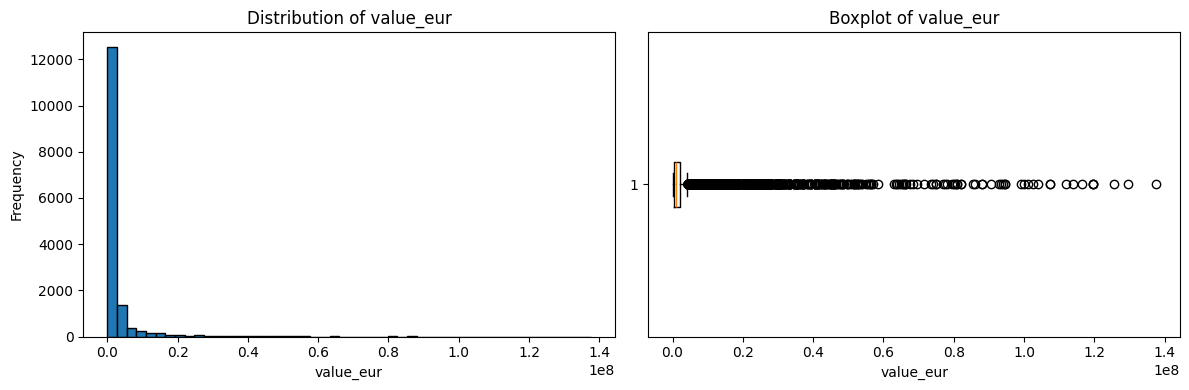

In [6]:
# Prepare side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram
axes[0].hist(train['value_eur'].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Distribution of value_eur')
axes[0].set_xlabel('value_eur')
axes[0].set_ylabel('Frequency')

# Boxplot
axes[1].boxplot(train['value_eur'].dropna(), vert=False)
axes[1].set_title('Boxplot of value_eur')
axes[1].set_xlabel('value_eur')

plt.tight_layout()
plt.show()

We can notice from the plots above that the distribution of the target variable is highly right skewed, therefore we log transform it.

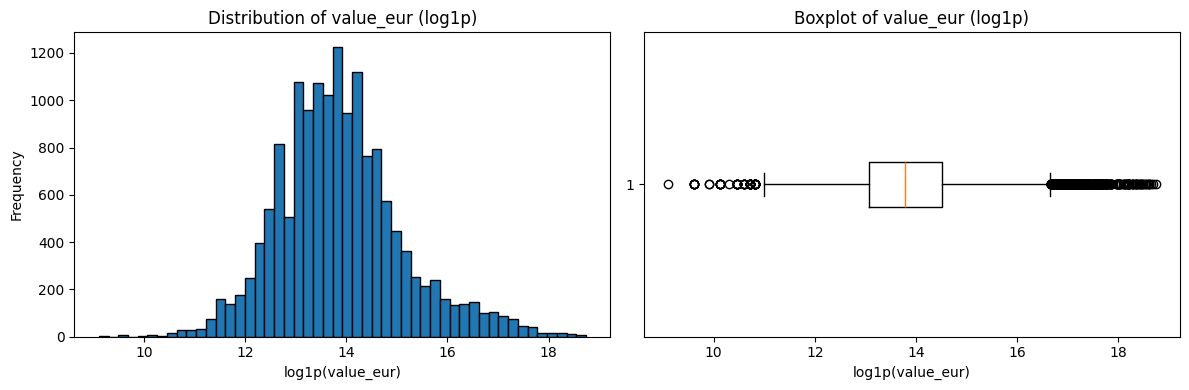

In [7]:
# Create the log-transformed target
log_target = np.log1p(train['value_eur'].clip(lower=0))

# Prepare side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram of log1p(value_eur)
axes[0].hist(log_target.dropna(), bins=50, edgecolor='black')
axes[0].set_title('Distribution of value_eur (log1p)')
axes[0].set_xlabel('log1p(value_eur)')
axes[0].set_ylabel('Frequency')

# Boxplot of log1p(value_eur)
axes[1].boxplot(log_target.dropna(), vert=False)
axes[1].set_title('Boxplot of value_eur (log1p)')
axes[1].set_xlabel('log1p(value_eur)')

plt.tight_layout()
plt.show()

### 1.4 Correlation among variables 

The correlation matrix below serves as a tool in our feature analysis, allowing us to detect multicollinearity among variables that may impact model performance.

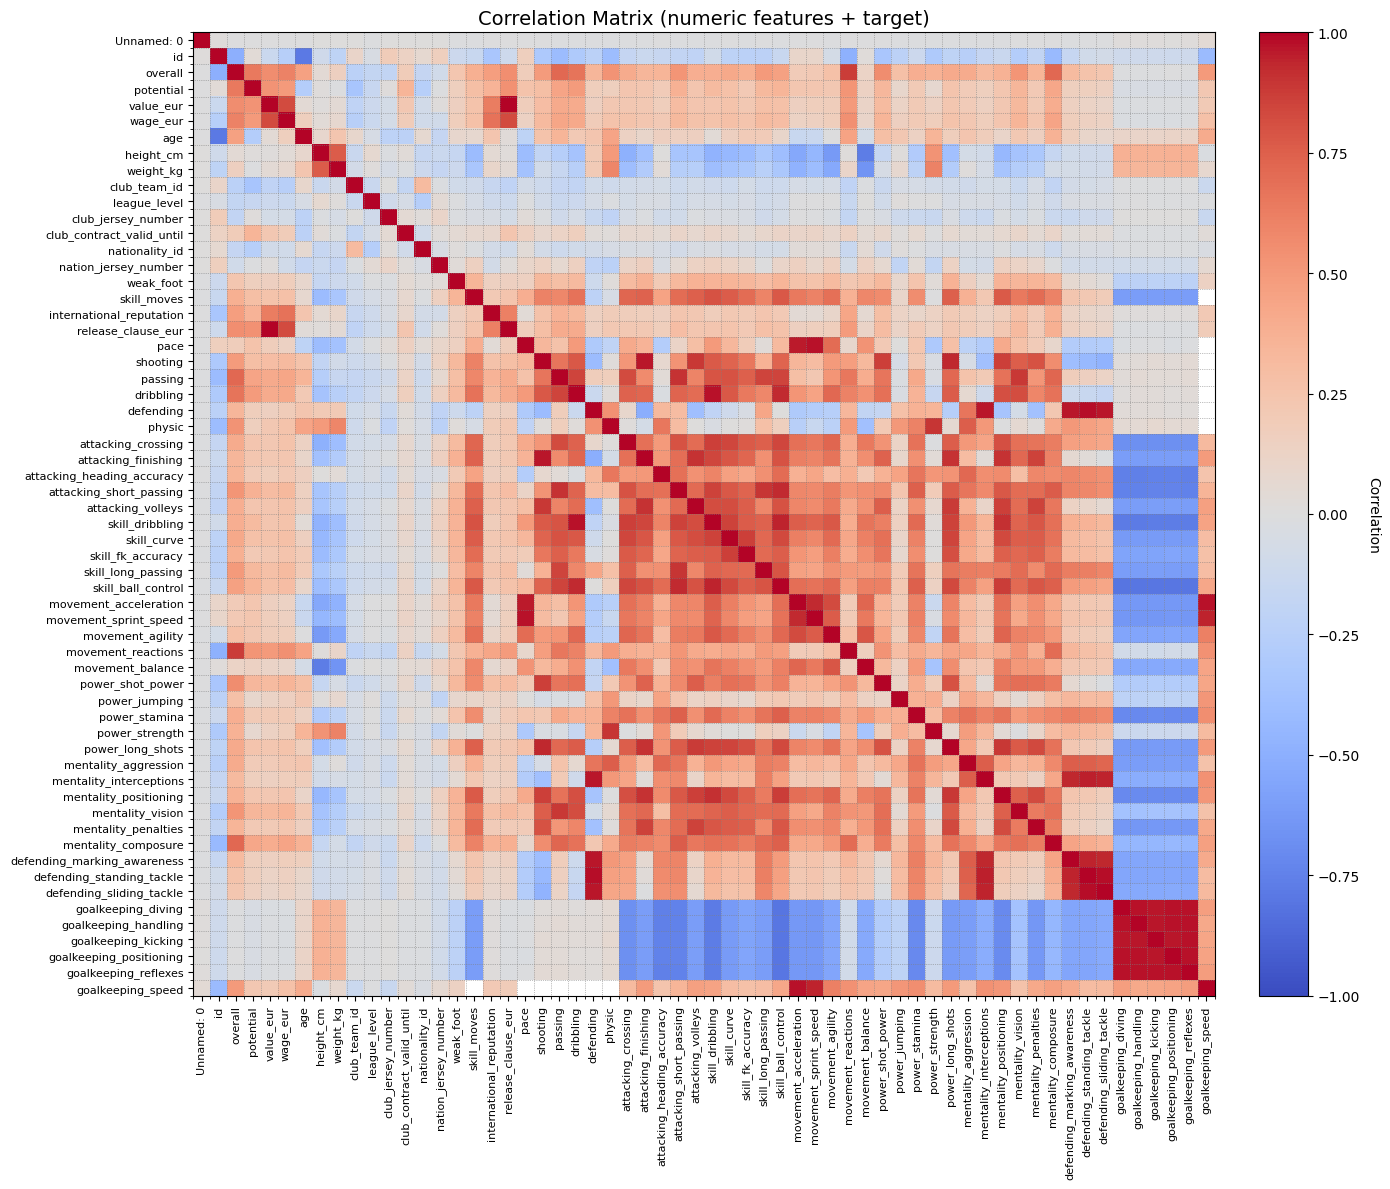

In [8]:
# Compute the correlation matrix for numeric columns only
corr = train.corr(numeric_only=True)

# Create figure and axis with larger size
fig, ax = plt.subplots(figsize=(14, 12))  # Bigger figure for readability

# Show correlation matrix with diverging color map for better contrast
im = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Set axis ticks and labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr.columns, fontsize=8)

# Add gridlines between cells
ax.set_xticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5)

# Add colorbar with label
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('Correlation', rotation=270, labelpad=15)

# Add title
ax.set_title("Correlation Matrix (numeric features + target)", fontsize=14)

# Tight layout for proper spacing
plt.tight_layout()
plt.show()


Calculate the correlation among the variables and identify pairs of features with high correlation (> 0.7). For each such pair, compare their correlation with the target variable value_eur, and append the one with the lower correlation in cols_to_drop to reduce redundancy while preserving predictive power.

In [9]:
# Define the target variable and correlation threshold
TARGET  = 'value_eur'
THRESH  = 0.70

# Find all pairs of features that are highly correlated with each other (above the threshold)
pairs = [(c1, c2)
         for c1 in corr.columns if c1 not in irrelevant_features and c1 not in drop_missing
         for c2 in corr.columns if c1 not in irrelevant_features and c2 not in drop_missing
         if c1 != c2 and abs(corr.loc[c1, c2]) > THRESH and TARGET not in (c1, c2)]

# Initialize a set to collect columns to drop (avoid duplicates)
cols_to_drop = set()

# Loop through each highly correlated pair
for c1, c2 in pairs:
    # Keep the feature more strongly correlated with the target
    if corr.loc[c1, TARGET] > corr.loc[c2, TARGET]:
        cols_to_drop.add(c2)  # Drop c2 if c1 is more useful
    else:
        cols_to_drop.add(c1)  # Drop c1 if c2 is more useful

# Print the number and names of columns flagged for removal
print(f"{len(cols_to_drop)} columns flagged:\n{cols_to_drop}")

# Calculate the columns left in the model
cols_left = [col for col in corr.columns if col not in cols_to_drop and col != TARGET and col not in irrelevant_features and col not in drop_missing]
print(f"\n{len(cols_left)} columns remaining in the model:\n{sorted(cols_left)}")


39 columns flagged:
{'mentality_positioning', 'movement_acceleration', 'mentality_vision', 'defending_sliding_tackle', 'skill_long_passing', 'power_strength', 'movement_balance', 'mentality_interceptions', 'goalkeeping_handling', 'attacking_crossing', 'wage_eur', 'mentality_penalties', 'attacking_heading_accuracy', 'movement_sprint_speed', 'attacking_short_passing', 'defending_standing_tackle', 'goalkeeping_positioning', 'height_cm', 'skill_dribbling', 'attacking_finishing', 'movement_agility', 'goalkeeping_reflexes', 'skill_fk_accuracy', 'passing', 'defending_marking_awareness', 'power_stamina', 'skill_ball_control', 'shooting', 'goalkeeping_kicking', 'movement_reactions', 'goalkeeping_diving', 'power_long_shots', 'dribbling', 'attacking_volleys', 'id', 'mentality_aggression', 'mentality_composure', 'skill_moves', 'skill_curve'}

14 columns remaining in the model:
['age', 'club_contract_valid_until', 'defending', 'international_reputation', 'league_level', 'overall', 'pace', 'physic',

### 1.5 Variables distributions
After excluding variables previously flagged for removal due to multicollinearity (cols_to_drop), irrelevant features (irrelevant_features), and those with the highest proportion of missing values, we are left with 16 numerical variables. For each of these, we plot both a histogram and a scatterplot against the log-transformed target (log(value_eur)) to examine their distributions and evaluate whether any transformation is necessary.

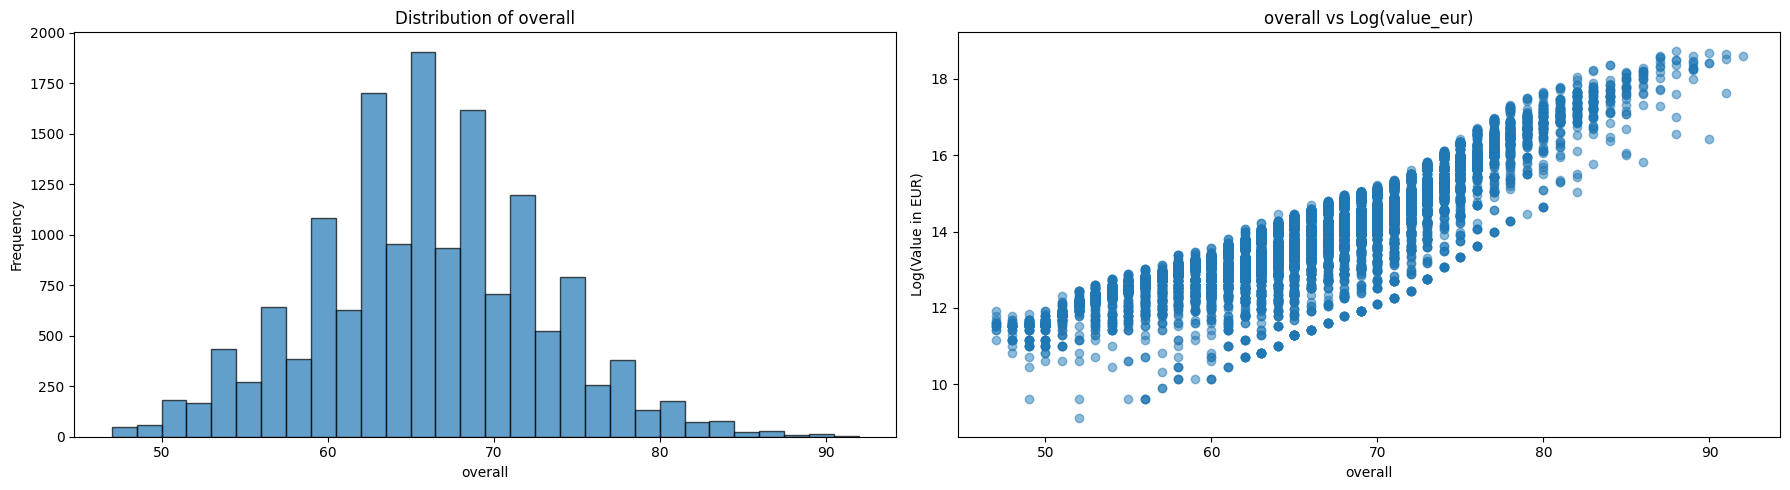

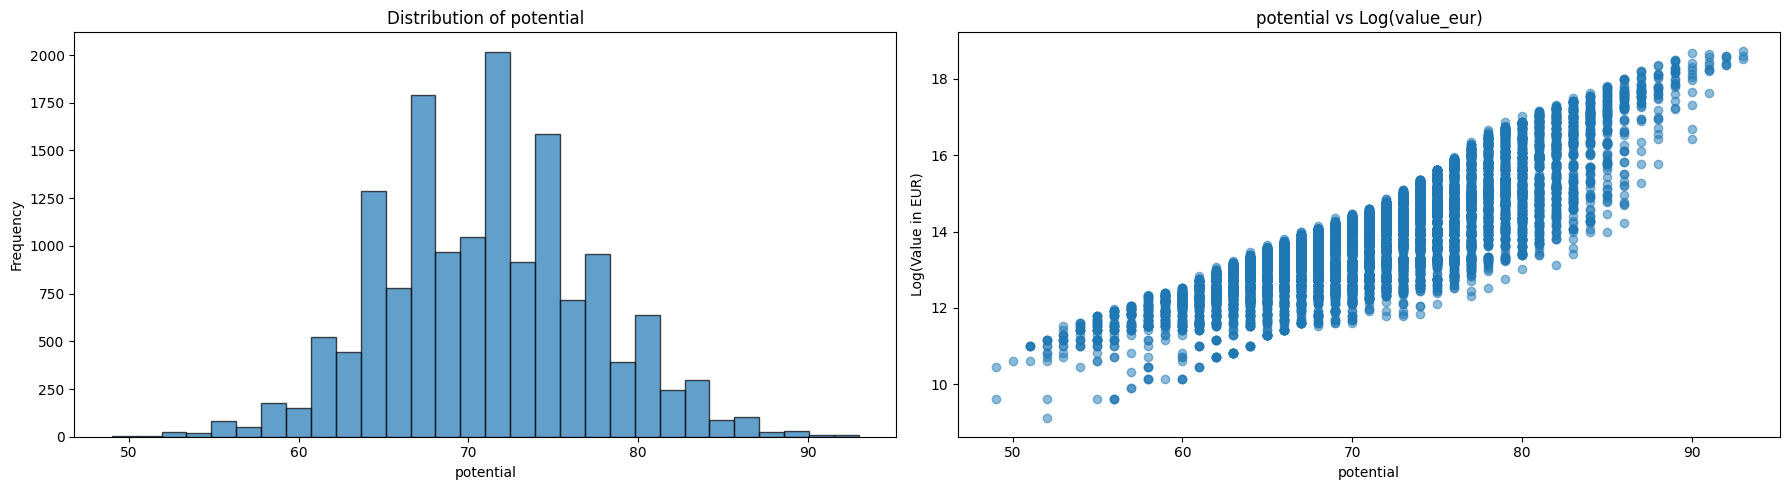

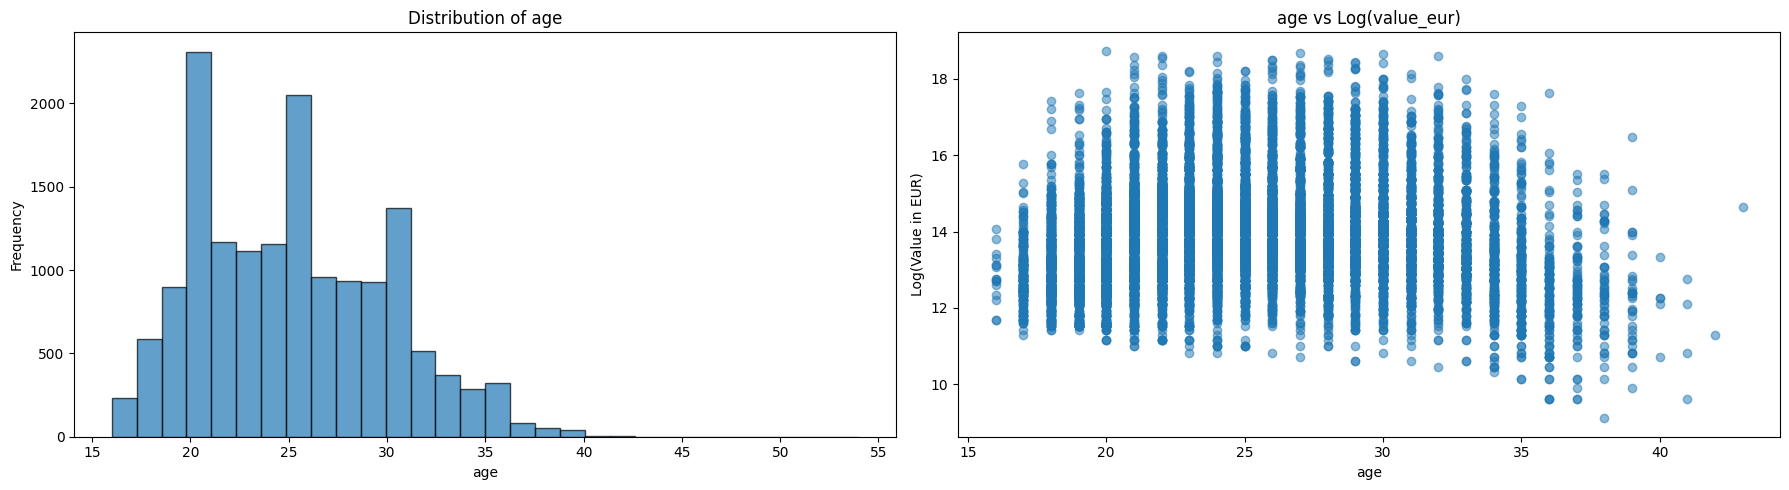

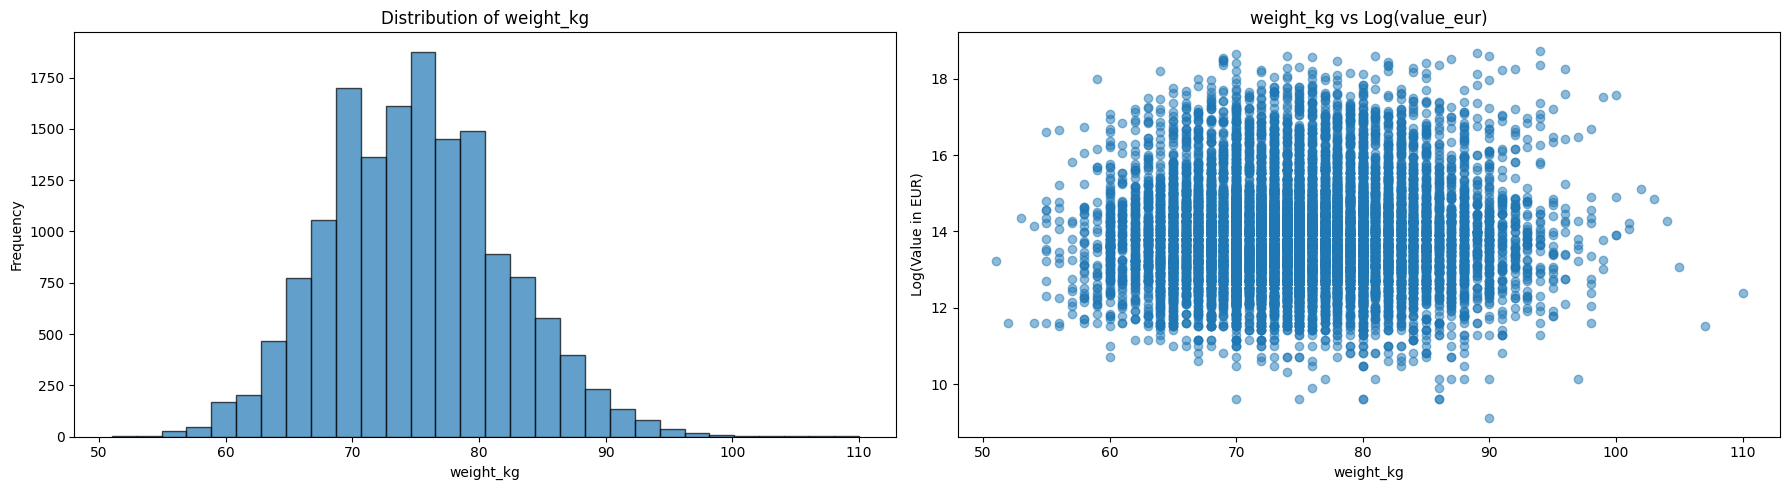

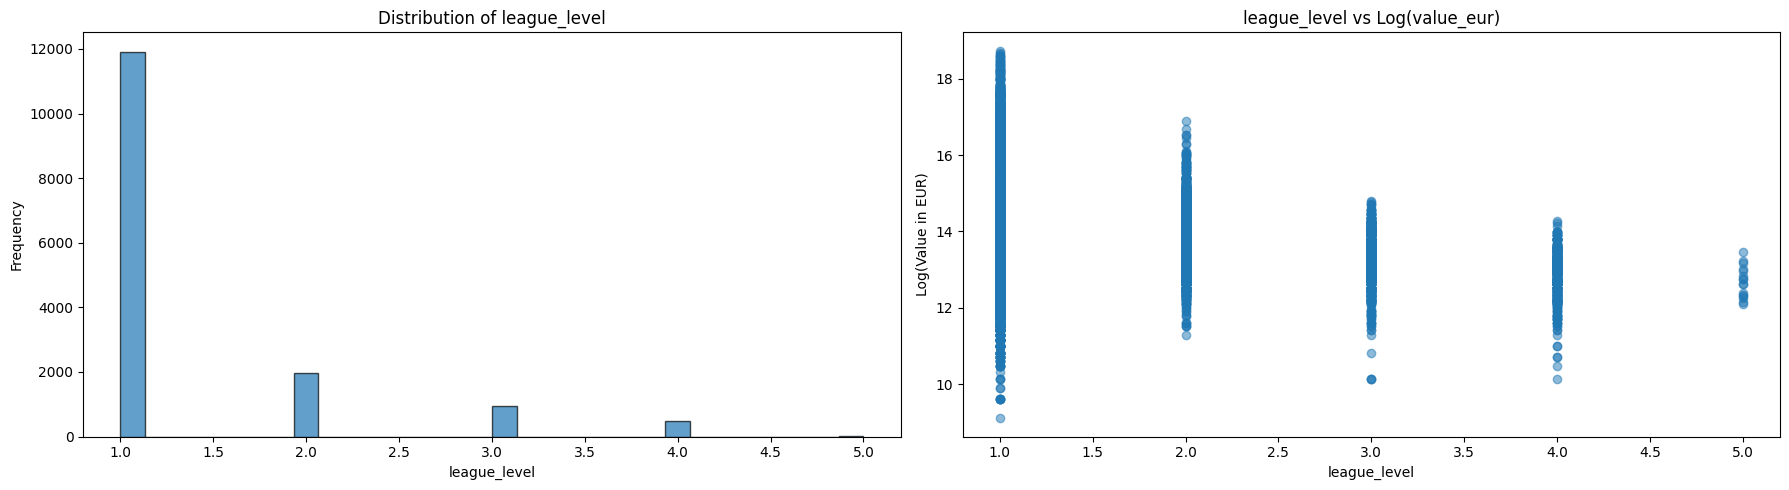

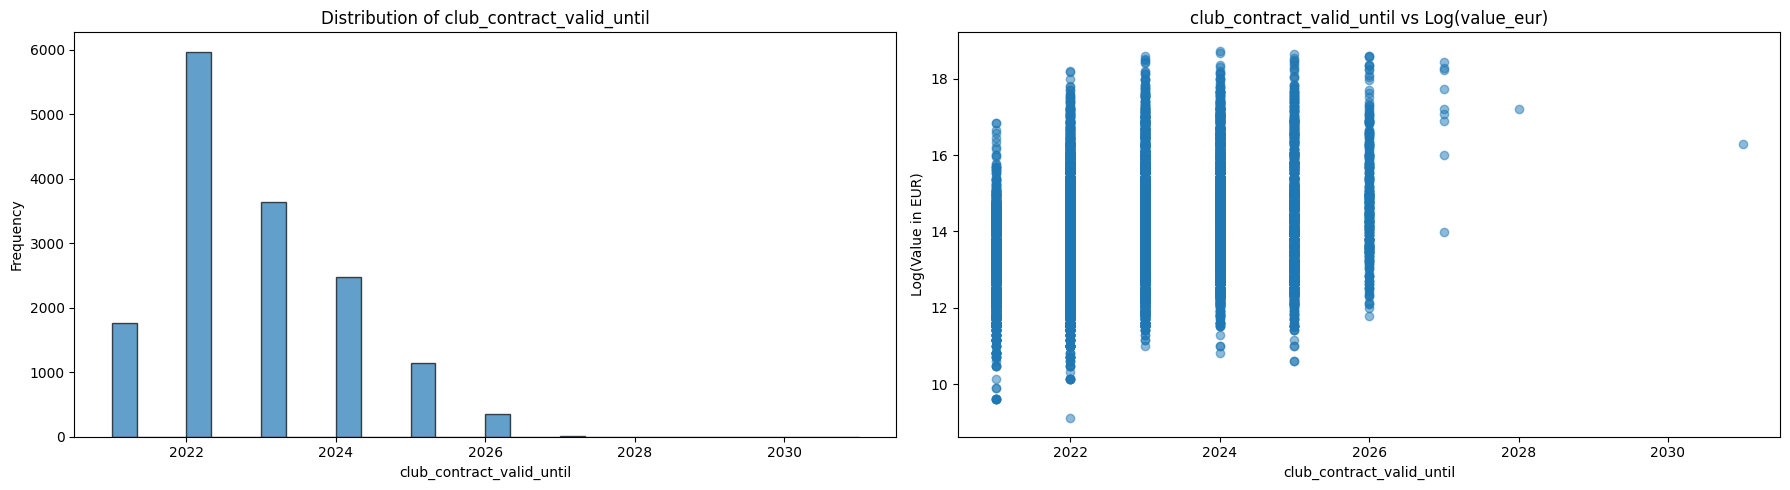

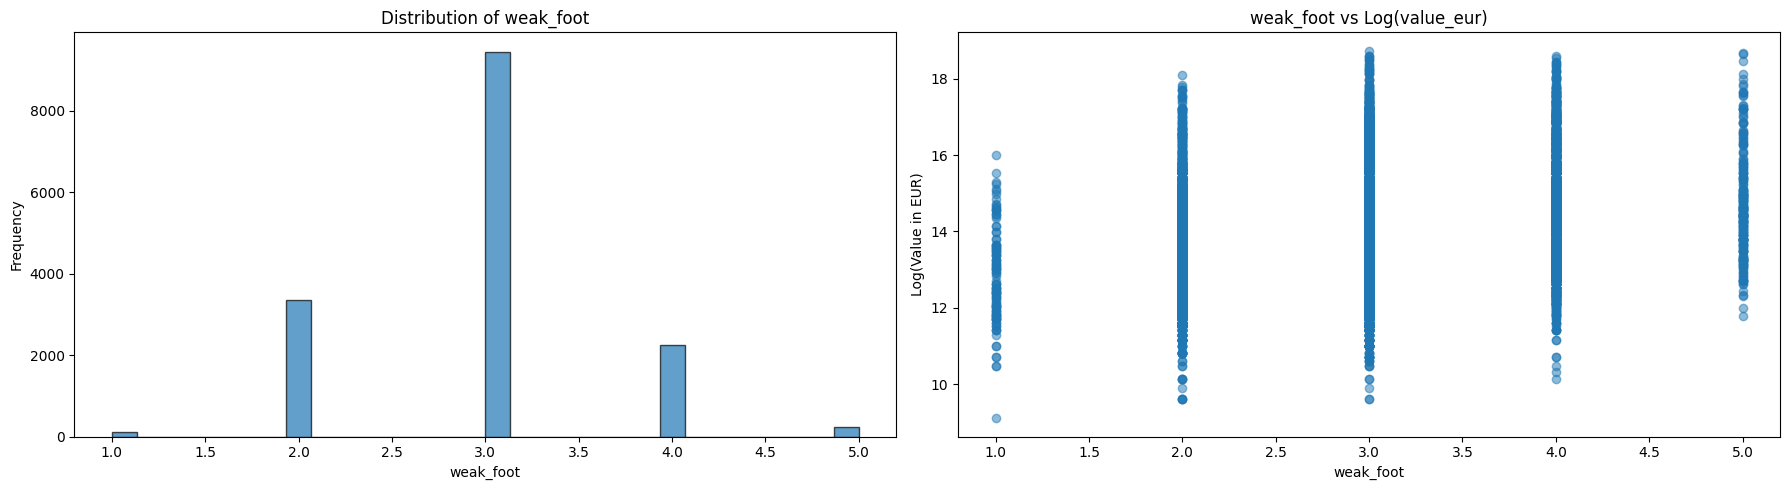

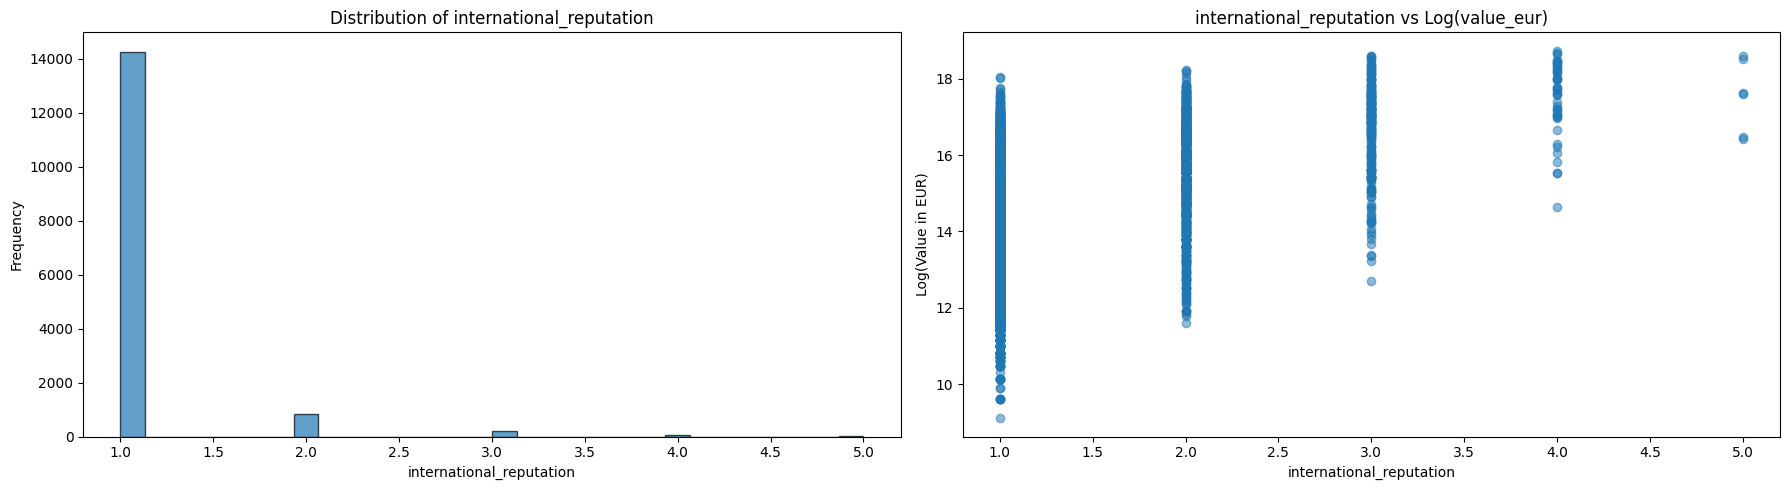

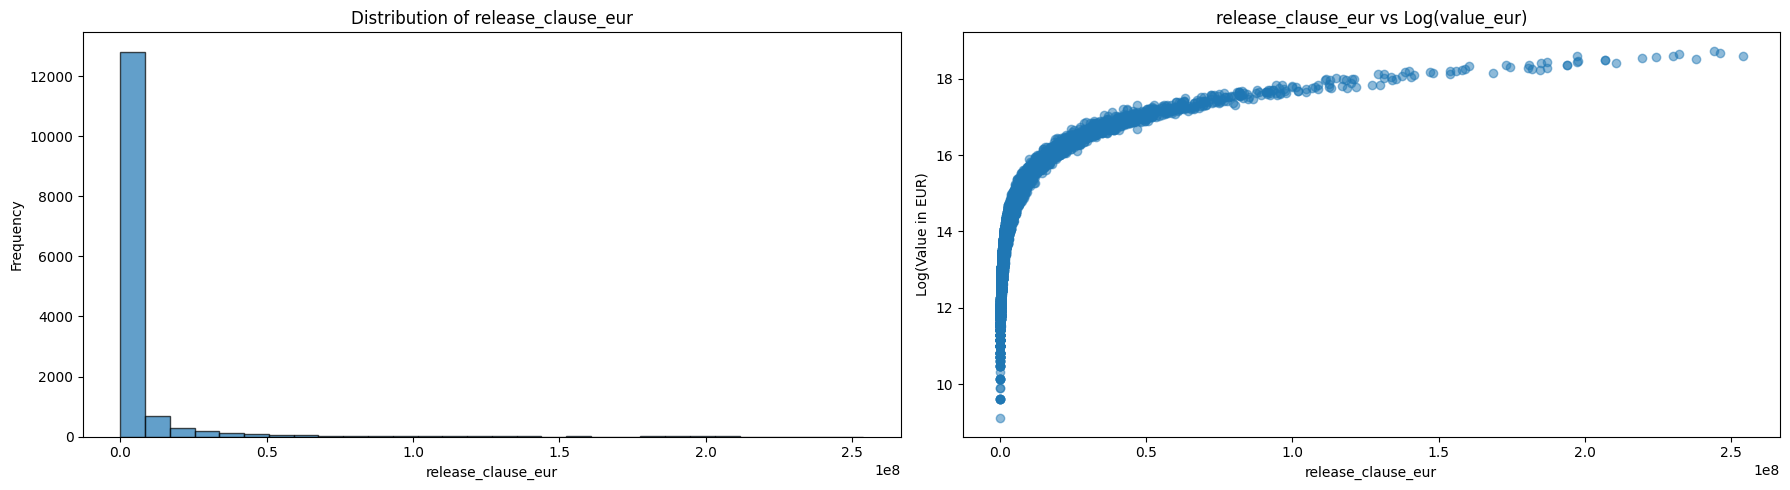

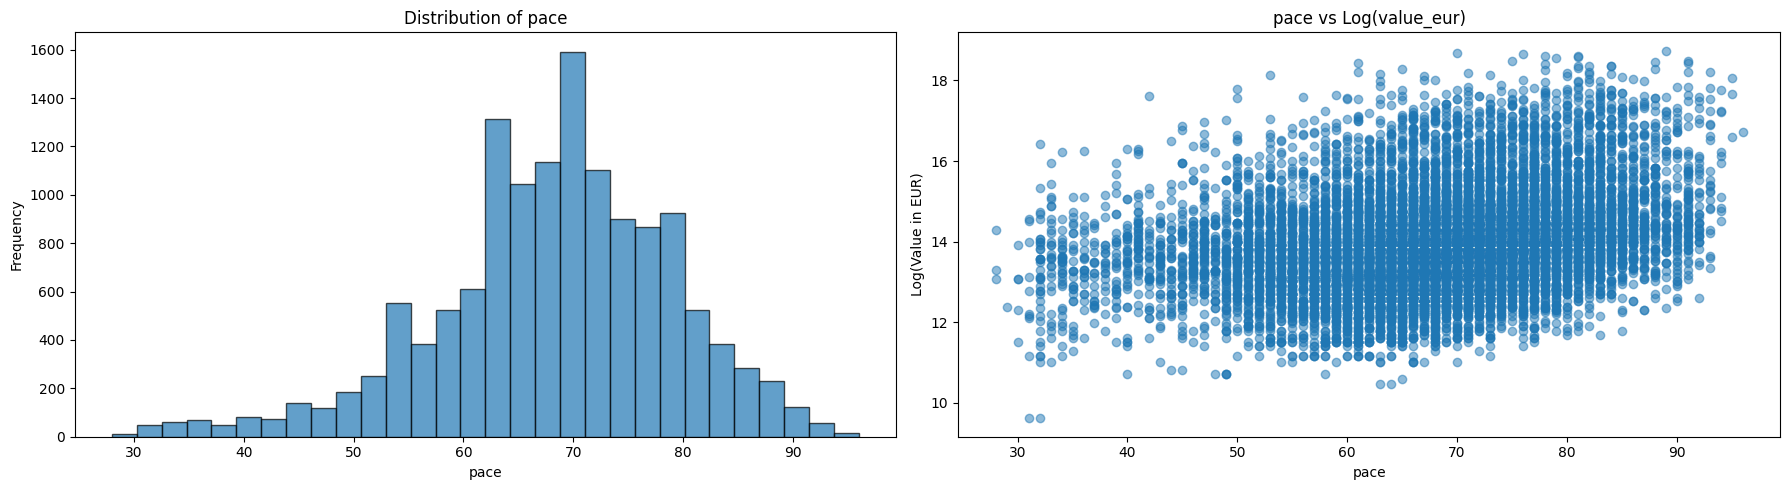

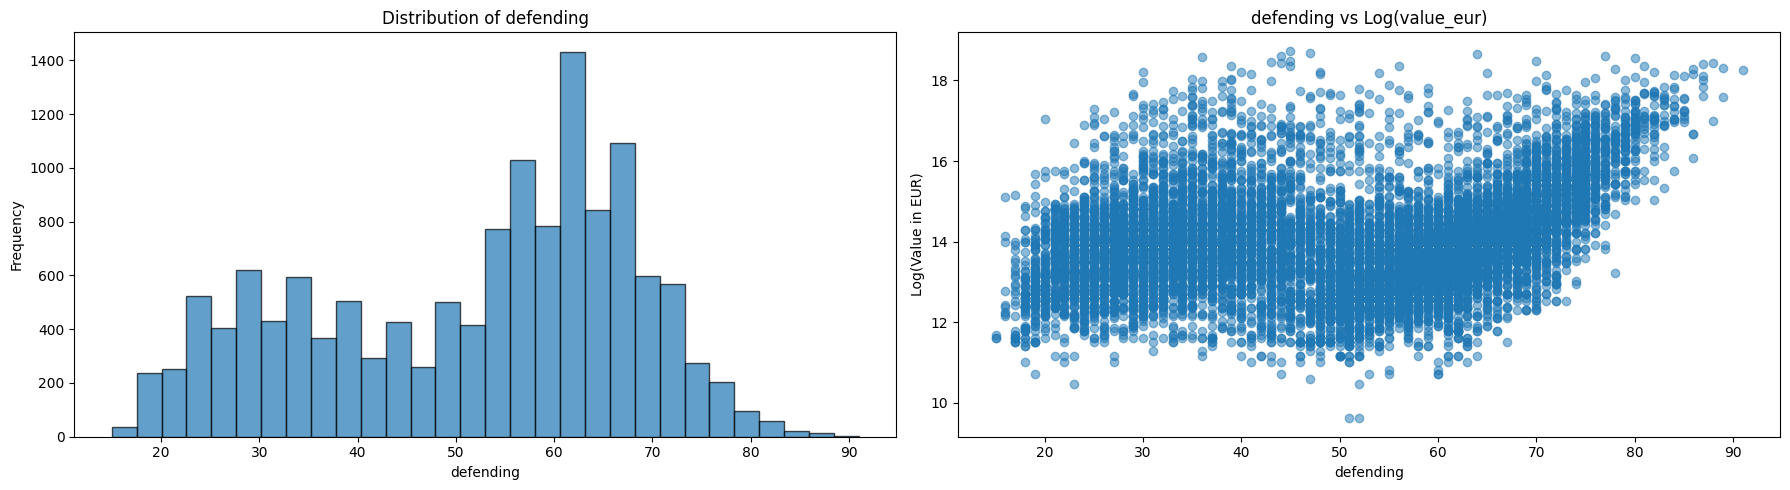

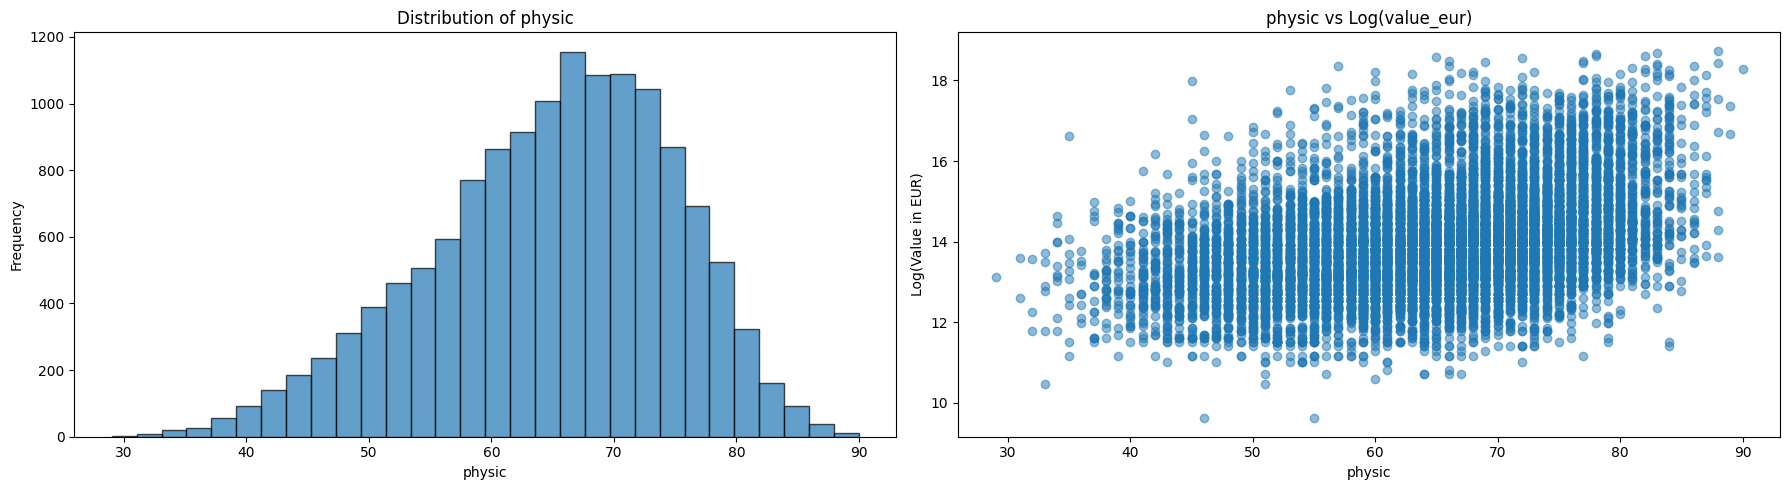

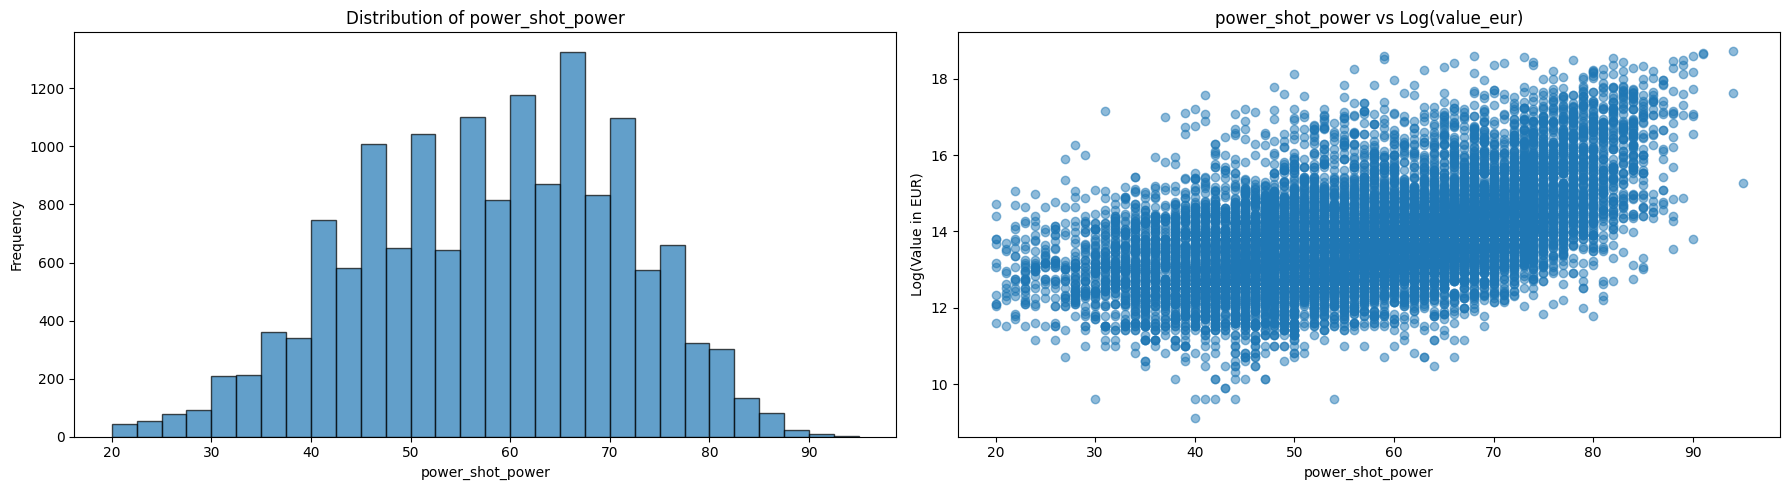

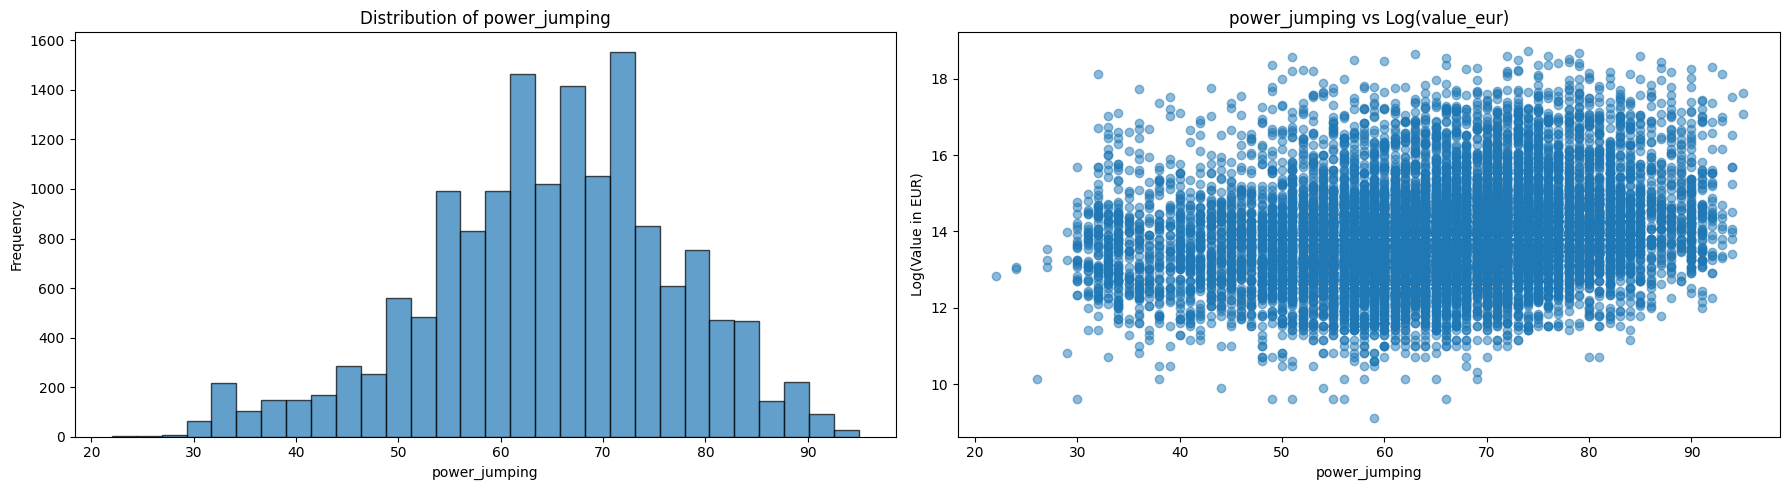

In [10]:
# Loop through each variable
for col in cols_left:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 3 plots side-by-side
    
    # Histogram
    axes[0].hist(train[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Scatterplot vs log(value_eur)
    axes[1].scatter(train[col], log_target, alpha=0.5)
    axes[1].set_title(f'{col} vs Log(value_eur)')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Log(Value in EUR)')

    plt.tight_layout()
    plt.show()

From the plots above, we observe that release_clause_eur is highly skewed and exhibits a nonlinear relationship with log(value_eur). Applying a logarithmic transformation helps linearize this relationship, making the feature more suitable for modeling.

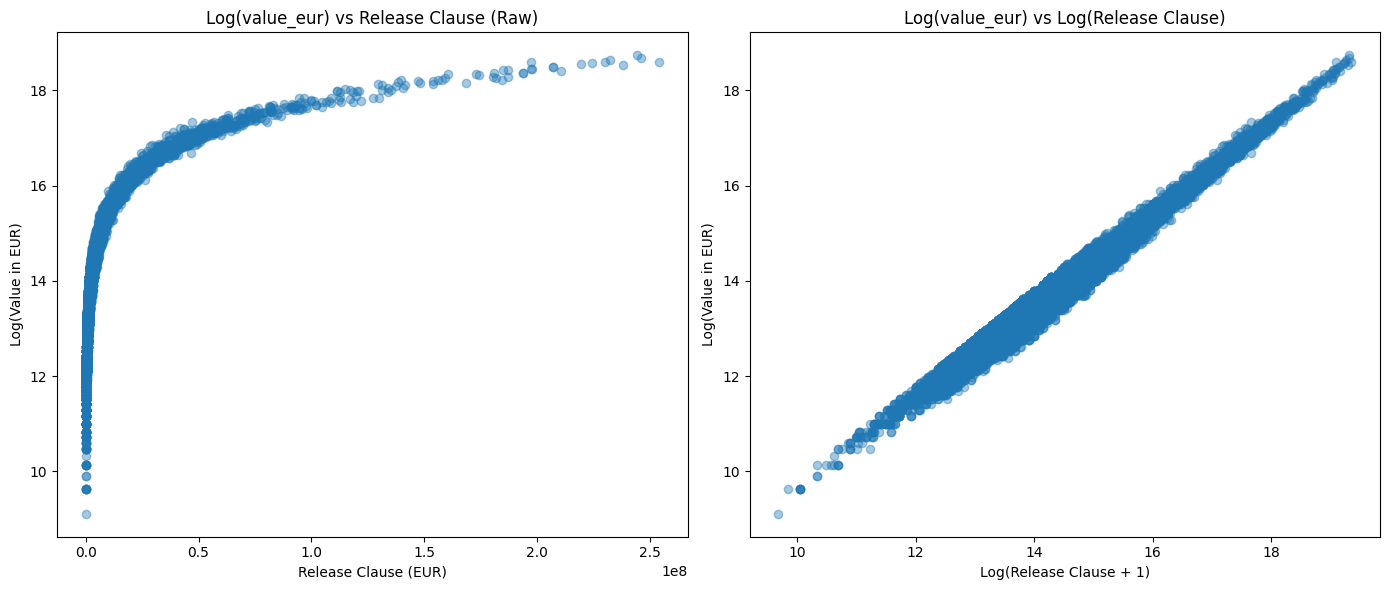

In [11]:
# Raw and log-transformed variables
raw_release = train['release_clause_eur']
log_release = np.log1p(raw_release)  # log(1 + x) handles zeros

# Side-by-side scatterplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot: Raw release_clause_eur vs log(value_eur)
axes[0].scatter(raw_release, log_target, alpha=0.4)
axes[0].set_title("Log(value_eur) vs Release Clause (Raw)")
axes[0].set_xlabel("Release Clause (EUR)")
axes[0].set_ylabel("Log(Value in EUR)")

# Plot: Log-transformed release_clause_eur vs log(value_eur)
axes[1].scatter(log_release, log_target, alpha=0.4)
axes[1].set_title("Log(value_eur) vs Log(Release Clause)")
axes[1].set_xlabel("Log(Release Clause + 1)")
axes[1].set_ylabel("Log(Value in EUR)")

plt.tight_layout()
plt.show()


## 2. Preprocessing 

We define a function to load and clean the dataset, along with a separate preprocessing function that applies minimal transformations. This setup allows us to easily reuse the cleaning and preprocessing steps across different models.

In [13]:
def load_and_clean(filepath):
    # 1) Load the dataset and drop rows where the target variable 'value_eur' is missing
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['value_eur'])
    
    # 2a) Separate the target variable
    y = df.pop('value_eur') # Remove 'value_eur' from df and store in y
    X = df.copy() # Create a copy of the features

    # 2b) Log-transform the target to reduce skewness
    y = np.log1p(y) # log1p = log(1 + x), handles zero values safely

    # 3a) Drop the features that miss more than 15% of their values
    X = X.drop(columns=drop_missing)

    # 3b) Remove previously identified irrelevant features 
    X = X.drop(columns=irrelevant_features)
    
    # 3c) Convert 'club_joined' to datetime and extract the year
    X['club_joined'] = pd.to_datetime(X['club_joined'], errors='coerce') # convert to datetime
    X['club_joined_year'] = X['club_joined'].dt.year # extract just the year
    X = X.drop(columns=['club_joined']) # original column no longer needed
    
    return X, y  # return cleaned features and transformed target

Define the preprocessor for numeric and categorical features.

In [14]:
preprocessor = ColumnTransformer([
    # Numeric preprocessing: median imputation + standard scaling
    ('num',
       Pipeline([
           ('imputer', SimpleImputer(strategy='median')),   # fill missing numeric with median
           ('scaler',   StandardScaler())                   # standardize numeric features
       ]),
       make_column_selector(dtype_include=np.number)        # apply to numeric columns only
    ),
    # Categorical preprocessing: constant imputation + one-hot encoding
    ('cat',
       Pipeline([
           ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')), # fill missing categorical with 'MISSING'
           ('onehot',  OneHotEncoder(handle_unknown='ignore',                     # convert categories to binary features
                                     sparse_output=False))
       ]),
       make_column_selector(dtype_exclude=np.number)                              # apply to categorical columns only 
    )
],
    remainder='drop'  # drop any remaining columns not explicitly handled
)

## 3. Feature engineering 

Here we define a custom transformer to apply additional feature engineering. This includes dropping variables that introduce multicollinearity (cols_to_drop), applying a logarithmic transformation to release_clause_eur to ensure a more linear relationship with value_eur (as shown above), and simplifying player positions into broader role categories to reduce dimensionality and mitigate overfitting.

In [15]:
def feat_eng(df, *, cols_to_drop=cols_to_drop):

    # Make a copy of the input DataFrame, dropping unwanted columns (ignore errors if missing)
    X = df.drop(columns=cols_to_drop, errors='ignore').copy()

    # Log-transform release_clause_eur to reduce skew and improve linearity 
    if 'release_clause_eur' in X:
        X['release_clause_eur'] = np.log1p(X['release_clause_eur'])

    # Create role-based dummy variables from 'player_positions' 
    if 'player_positions' in X:
        # Define a mapping from specific positions to general role groups
        role_to_group = {
            'GK': 'Goalkeeper',
            'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender',
            'LWB': 'Defender', 'RWB': 'Defender',
            'CDM': 'Midfielder', 'CM': 'Midfielder', 'CAM': 'Midfielder',
            'LM': 'Midfielder', 'RM': 'Midfielder',
            'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward'
        }

        # Initialize dummy columns to 0
        X['is_defender']   = 0
        X['is_midfielder'] = 0
        X['is_forward']    = 0
        X['is_goalkeeper'] = 0

        # Iterate over non-null 'player_positions' values
        for idx, pos in X['player_positions'].dropna().items():
            roles = [r.strip() for r in pos.split(',')]  # Split multiple roles
            groups = {role_to_group.get(r, 'Goalkeeper') for r in roles}  # Map to groups

            # Set dummy flags if player's role matches the group
            if 'Defender'   in groups: X.at[idx, 'is_defender']   = 1
            if 'Midfielder' in groups: X.at[idx, 'is_midfielder'] = 1
            if 'Forward'    in groups: X.at[idx, 'is_forward']    = 1
            if 'Goalkeeper' in groups: X.at[idx, 'is_goalkeeper'] = 1

        # Drop the original column after encoding
        X = X.drop(columns=['player_positions'])

    return X

# Wrap the feature engineering function as a scikit-learn-compatible transformer
feat_eng_step = FunctionTransformer(
    feat_eng,
    validate=False,  # Skip strict input validation to keep DataFrames
    kw_args={'cols_to_drop': cols_to_drop}  # Pass in the list of columns to drop
)


## 4. Baseline model 

Let's define our scorers that we will use to assess the performance of our models later.

In [16]:
# Custom RMSE function in EUR (not log-space)
def rmse_eur(log_true, log_pred):
    # Convert predictions and true values back from log-space using expm1 (inverse of log1p)
    return np.sqrt(mean_squared_error(np.expm1(log_true), np.expm1(log_pred)))

# Define a scorer to use with cross_val_score or GridSearchCV
eur_rmse = make_scorer(rmse_eur, greater_is_better=False)  # minimise RMSE

# Utility function to format mean ± std for output
def fmt(mean, std, decimals=0):
    return f"{mean:.{decimals}f} ± {std:.{decimals}f}"

### 4.1 Linear Regression

We trained a Linear Regression model on the preprocessed data and evaluated its performance using cross-validation. The results, reported below, reflect the model's average performance across multiple folds using standard regression metrics.

In [17]:
# Load data
X, y = load_and_clean('data/train.csv')

# Build Linear Regression pipeline
pipeline = Pipeline([
    ('feat_eng',  feat_eng_step),
    ('preprocess', preprocessor),
    ('model',      LinearRegression())
])

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# Run cross-validation using RMSE scorer
cv_res = cross_validate(
    pipeline, X, y,
    scoring={"rmse": eur_rmse},
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

# Extract and convert RMSE scores (make positive since scorer returns negative)
train_rmse = -cv_res["train_rmse"]
val_rmse   = -cv_res["test_rmse"]

# Print results
print("── 5-fold cross-validation RMSE (EUR) ──")
print(f"Train RMSE : {fmt(train_rmse.mean(), train_rmse.std())}")
print(f"Val   RMSE : {fmt(val_rmse.mean(),   val_rmse.std())}")

── 5-fold cross-validation RMSE (EUR) ──
Train RMSE : 1788367 ± 70968
Val   RMSE : 1901023 ± 311359


The validation RMSE is only about 5% higher than the training RMSE, indicating relatively low overfitting. However, the absolute error values remain quite high, suggesting that a simple linear model may not fully capture the underlying complexity of the data. More flexible models or further feature engineering may be needed to improve performance.

### 4.2 Lasso 
As another baseline model, we chose Lasso Regression because it automatically selects the most important features by setting many coefficients to zero. Since Lasso already performs regularization and feature selection, we applied only minimal preprocessing—basic imputation and scaling—keeping the model simple and easy to interpret.

In [70]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# Define a range of alpha values to search for regularization strength
# We use a log scale between 1e-5 and 1e-3 (20 values)
alpha_search = np.logspace(-5, -3, 20)

# Create a pipeline with LassoCV to automatically select the best alpha
pipeline_cv = Pipeline([
    ('feat_eng',  feat_eng_step), # Apply custom feature engineering
    ('preprocess', preprocessor), # Handle missing values, scale numerics, encode categoricals
    ('model', LassoCV(
        alphas=alpha_search,    # Try different alpha values from the search space
        cv=5,                   # Internal 5-fold CV used by LassoCV to select alpha
        max_iter=10_000, 
        n_jobs=-1, 
        random_state=42))
])

# Fit the pipeline with LassoCV to the entire dataset
pipeline_cv.fit(X, y)
best_alpha = pipeline_cv.named_steps['model'].alpha_
print(f"Best α from internal CV: {best_alpha:.6f}")

# Final pipeline using best alpha
pipeline = Pipeline([
    ('feat_eng',  feat_eng_step),
    ('preprocess', preprocessor),
    ('model', Lasso(
        alpha=best_alpha,       # Use the best alpha found
        max_iter=10_000))
])

# Use external 5-fold cross-validation to evaluate the final Lasso model
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# Evaluate the model using custom RMSE scorer 
cv_res = cross_validate(
    pipeline, X, y,
    scoring={"rmse": eur_rmse},
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

# Convert RMSE results to positive values (since scorers return negative for minimization)
train_rmse = -cv_res["train_rmse"]
val_rmse   = -cv_res["test_rmse"]

# Print results
print("── 5-fold cross-validation RMSE (EUR) ──")
print(f"Train RMSE : {fmt(train_rmse.mean(), train_rmse.std())}")
print(f"Val   RMSE : {fmt(val_rmse.mean(),   val_rmse.std())}")


Best α from internal CV: 0.000070
── 5-fold cross-validation RMSE (EUR) ──
Train RMSE : 1763489 ± 49188
Val   RMSE : 1827485 ± 276117


## 5. Complex Models 

We now move on to fitting more complex models to improve predictive performance.

### 5.1 Decision Tree

In [76]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# Decision Tree Pipeline
tree_pipe = Pipeline(steps=[
    ("feat_eng", feat_eng_step),          
    ("prep"    , preprocessor),           
    ("model"   , DecisionTreeRegressor(
        random_state=18,                  # reproducibility
        min_samples_leaf=5,               # tuned parameter
    )),
])

# Hyper-parameter grid  
param_grid = {
    "model__max_depth":        [None, 10, 20, 30],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__ccp_alpha":        [0.0, 0.0005, 0.001, 0.005],
}

# Define 5-fold cross-validation strategy with shuffled splits
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# GridSearchCV to find best hyperparameters based on euro-scale RMSE
gs = GridSearchCV(
    tree_pipe,            # Pipeline to tune
    param_grid,           # Parameter grid to search
    scoring=eur_rmse,     # Custom RMSE scorer
    cv=cv,                # 5-fold CV
    n_jobs=-1,            # Use all available CPU cores
    return_train_score=True,
)

# Fit grid-search on the full dataset
gs.fit(X, y)

# Print the best combination of hyperparameters and corresponding CV score
print("\nBest hyper-parameters:", gs.best_params_)
print(f"Best CV RMSE (EUR): {-gs.best_score_:,.0f}")

# Tuned Decision-Tree pipeline, refit on all data
best_tree_pipe = gs.best_estimator_


Best hyper-parameters: {'model__ccp_alpha': 0.0, 'model__max_depth': 20, 'model__min_samples_leaf': 5}
Best CV RMSE (EUR): 919,318


### 5.2 Random Forest

In [85]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# Random Forest Pipeline
rf_pipe = Pipeline([
    ("feat_eng", feat_eng_step),     
    ("prep"    , preprocessor),      
    ("model"   , RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        random_state=18,
        n_jobs=-1
    )),
])

# Hyper-parameter grid 
param_grid = {
    "model__n_estimators":     [300, 500, 700],
    "model__max_depth":        [None, 20, 30],
    "model__min_samples_leaf": [2, 5, 10],
}

# Define 5-fold cross-validation strategy with shuffled splits
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# GridSearchCV to find best hyperparameters based on euro-scale RMSE
gs = GridSearchCV(
    rf_pipe,              # Pipeline to tune
    param_grid,           # Parameter grid to search
    scoring=eur_rmse,     # Custom RMSE scorer
    cv=cv,                # 5-fold CV
    n_jobs=-1,            # Use all available CPU cores
    return_train_score=True,
)

# Fit grid-search on the full dataset
gs.fit(X, y)


print("\nBest hyper-parameters:", gs.best_params_)
print(f"Best CV RMSE (EUR): {-gs.best_score_:,.0f}")


# Tuned Random Forest pipeline, refit on all data
best_rf_pipe = gs.best_estimator_   

ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: BaseForest.fit() got an unexpected keyword argument 'early_stopping_rounds'


### 5.3 XGBoost 

In [20]:
# Load features and target from the cleaned dataset
X, y = load_and_clean('data/train.csv')

# XGBoost Pipeline
xgb_pipe = Pipeline([
    ("feat_eng", feat_eng_step),     
    ("prep"    , preprocessor),      
    ("model"   , XGBRegressor(
        objective="reg:squarederror",  # for regression
        eval_metric   = "rmse",
        random_state=18,
        n_jobs=-1,
        verbosity=0,
        tree_method   = "hist"      # speed-up
    ))
])

# Hyper-parameter grid 
param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [2, 3],
    "model__learning_rate": [0.05, 0.1],
    "model__subsample": [0.7, 1.0],
    "model__colsample_bytree": [0.7, 1.0],
    "model__reg_alpha": [0, 1],
    "model__reg_lambda": [1, 5],
    "model__min_child_weight":  [1, 5], # makes each tree less likely to over-fit
    "model__gamma":             [0, 0.2] # makes each tree less likely to over-fit
}

# Define 5-fold cross-validation strategy with shuffled splits
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# GridSearchCV to find best hyperparameters based on euro-scale RMSE
gs = GridSearchCV(
    xgb_pipe,               # Pipeline to tune
    param_grid,             # Parameter grid to search
    scoring=eur_rmse,       # Custom RMSE scorer
    cv=cv,                  # 5-fold CV
    n_jobs=-1,              # Use all available CPU cores
    return_train_score=True
)

# Early stopping via the new callback interface
early_stop = xgb.callback.EarlyStopping(rounds=50, save_best=True, maximize=False)

# Fit grid-search on the full dataset
gs.fit(X, y)

print("\nBest hyper-parameters:", gs.best_params_)
print(f"Best CV RMSE (EUR): {-gs.best_score_:,.0f}")

# Tuned XGBoost pipeline, refit on all data
best_xgb_pipe = gs.best_estimator_   


Best hyper-parameters: {'model__colsample_bytree': 0.7, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 500, 'model__reg_alpha': 0, 'model__reg_lambda': 1, 'model__subsample': 0.7}
Best CV RMSE (EUR): 742,199



Best hyper-parameters: {'model__colsample_bytree': 0.7, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 500, 'model__reg_alpha': 0, 'model__reg_lambda': 1, 'model__subsample': 0.7}
Best CV RMSE (EUR): 742,199


In [23]:
# Load your custom functions and pipeline steps
X, y = load_and_clean('data/train.csv')

cv = KFold(n_splits=5, shuffle=True, random_state= 18)

cv_xgb_res = cross_validate(
    best_xgb_pipe, X, y,
    scoring={"rmse": eur_rmse},
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)

# Extract and convert RMSE scores (make positive since scorer returns negative)
train_rmse = -cv_xgb_res["train_rmse"]
val_rmse   = -cv_xgb_res["test_rmse"]

# Print results
print("── 5-fold cross-validation RMSE (EUR) ──")
print(f"Train RMSE : {fmt(train_rmse.mean(), train_rmse.std())}")
print(f"Val   RMSE : {fmt(val_rmse.mean(),   val_rmse.std())}")


── 5-fold cross-validation RMSE (EUR) ──
Train RMSE : 515601 ± 31172
Val   RMSE : 742199 ± 159990


In [24]:
515601/742199

0.6946937411664527